In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import copy

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.under_sampling import RandomUnderSampler

In [2]:
df = pd.read_parquet("costco_2021_reviews_filtered_vectorized_master_en_32_no_duplicates.parquet")
df

,user_id,name,time,rating,text,gmap_id,vector
0,108341711662008461816,Rod Powell,1580509229183,5,Great service. Nice folks. Very helpful.,0x88626b6a29df9fb1:0x868c85d23dc91564,"[0.0068788542, 0.029086296, -0.011112881, 0.00..."
1,100886664024661856987,zach smithson,1489608374532,5,Amazing how much cheaper their hearing aids ar...,0x88626b6a29df9fb1:0x868c85d23dc91564,"[-0.05165099, 0.008153723, -0.04912399, 0.0030..."
2,104116808865576923879,George “Stovie” Moore,1623169525640,1,"I find Hoover, Alabama Costco’s tire service t...",0x888922182c25426d:0xabf1b10efa159b19,"[-0.014003422, 0.008204368, 0.011449834, 0.019..."
3,113636820761208623071,Erica Disbrow,1613357729329,5,"Lambert was so nice, professional, and caring!...",0x888922182c25426d:0xabf1b10efa159b19,"[-0.010003155, 0.01936056, -0.009762309, 0.020..."
4,101232786196219574483,Roy Martin,1613138521284,5,I needed new tires and Costco's price was $400...,0x888922182c25426d:0xabf1b10efa159b19,"[-0.043057095, 0.019696508, 0.003782874, 0.008..."
...,...,...,...,...,...,...,...
866537,108851483128030774999,Odysseas,1458534609705,5,It's Costco.,0x8807a8cdc249ad79:0x3fdbf3ca7f0a43bf,"[-0.03667649, -0.01456362, -0.01608518, 0.0076..."
866538,105468512214130057994,Chuck Anderson,1431844304443,5,Outstanding,0x8807a8cdc249ad79:0x3fdbf3ca7f0a43bf,"[0.008467636, -0.014427097, -0.027180135, 0.00..."
866539,101071427934910005277,o Abdoko,1417168632053,5,nice place)),0x8807a8cdc249ad79:0x3fdbf3ca7f0a43bf,"[-0.034930643, 0.015595584, -0.0100806365, 0.0..."
866540,100180472161950539260,Bill Brasky,1351948282842,5,The actually pay the employees unlike Sams.,0x8807a8cdc249ad79:0x3fdbf3ca7f0a43bf,"[-0.0036253948, 0.0067303316, -0.025239518, -0..."


In [3]:
df = df.reset_index().drop(columns = 'index')

In [4]:
df

,user_id,name,time,rating,text,gmap_id,vector
0,108341711662008461816,Rod Powell,1580509229183,5,Great service. Nice folks. Very helpful.,0x88626b6a29df9fb1:0x868c85d23dc91564,"[0.0068788542, 0.029086296, -0.011112881, 0.00..."
1,100886664024661856987,zach smithson,1489608374532,5,Amazing how much cheaper their hearing aids ar...,0x88626b6a29df9fb1:0x868c85d23dc91564,"[-0.05165099, 0.008153723, -0.04912399, 0.0030..."
2,104116808865576923879,George “Stovie” Moore,1623169525640,1,"I find Hoover, Alabama Costco’s tire service t...",0x888922182c25426d:0xabf1b10efa159b19,"[-0.014003422, 0.008204368, 0.011449834, 0.019..."
3,113636820761208623071,Erica Disbrow,1613357729329,5,"Lambert was so nice, professional, and caring!...",0x888922182c25426d:0xabf1b10efa159b19,"[-0.010003155, 0.01936056, -0.009762309, 0.020..."
4,101232786196219574483,Roy Martin,1613138521284,5,I needed new tires and Costco's price was $400...,0x888922182c25426d:0xabf1b10efa159b19,"[-0.043057095, 0.019696508, 0.003782874, 0.008..."
...,...,...,...,...,...,...,...
792016,108851483128030774999,Odysseas,1458534609705,5,It's Costco.,0x8807a8cdc249ad79:0x3fdbf3ca7f0a43bf,"[-0.03667649, -0.01456362, -0.01608518, 0.0076..."
792017,105468512214130057994,Chuck Anderson,1431844304443,5,Outstanding,0x8807a8cdc249ad79:0x3fdbf3ca7f0a43bf,"[0.008467636, -0.014427097, -0.027180135, 0.00..."
792018,101071427934910005277,o Abdoko,1417168632053,5,nice place)),0x8807a8cdc249ad79:0x3fdbf3ca7f0a43bf,"[-0.034930643, 0.015595584, -0.0100806365, 0.0..."
792019,100180472161950539260,Bill Brasky,1351948282842,5,The actually pay the employees unlike Sams.,0x8807a8cdc249ad79:0x3fdbf3ca7f0a43bf,"[-0.0036253948, 0.0067303316, -0.025239518, -0..."


In [5]:
X = df['vector']
y = df['rating']

In [6]:
y = y.values.reshape(-1,1)
y.shape

(792021, 1)

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size = 0.2, random_state=123)

# splitting train set and validation set
# then we split it train set into 11-folds to build models

In [8]:
ohe_y_train = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(y_train)
y_train_ohe = ohe_y_train.transform(y_train)

ohe_y_val = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(y_val)
y_val_ohe = ohe_y_val.transform(y_val)

In [9]:
kfold = StratifiedKFold(n_splits=11,
                        shuffle=True,
                        random_state=123)

In [10]:
y_train

array([[5],
       [3],
       [5],
       ...,
       [5],
       [5],
       [5]], dtype=int64)

In [11]:
y_train_ohe

array([[0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [12]:
prob = torch.tensor(y_train_ohe).mean(dim=0)
prob

tensor([0.0497, 0.0238, 0.0611, 0.1956, 0.6699], dtype=torch.float64)

In [13]:
# FFN: Linear (1024,6) -> ReLU() -> Linear(6, 6) -> ReLU -> Linear(6, 5)

class Multiclass(nn.Module): # https://pytorch.org/docs/stable/generated/torch.nn.Module.html
    def __init__(self):
        super().__init__() # needed to use nn.Module
        self.input = nn.Linear(1024, 6) # input 1024 x 1 column vector
        self.act = nn.ReLU() # activation function
        self.hidden = nn.Linear(6, 6)
        self.output = nn.Linear(6, 5) # output 5 x 1 column vector

    def n_steps(self, x, n):
        for i in range(n):
            x = self.hidden(self.act(x))
        return x

    def forward(self, x):
        x = self.input(x)
        x = self.n_steps(x, 30)
        x = self.act(x)
        x = self.output(x)
        return x

In [14]:
# loss funtion to penalize unbalanced data

def loss_bal(y_batch):
    prob = y_batch.mean(dim=0)
    expected_value = prob * torch.tensor([1, 2, 3, 4, 5]).sum()
    loss = torch.mean((expected_value - 3)**2)

    return loss

In [15]:
c_entropy = nn.CrossEntropyLoss()

In [16]:
loss_bal(torch.tensor(y_train_ohe))

tensor(13.2223, dtype=torch.float64)

In [17]:
X_train = torch.tensor(X_train.to_list(), dtype = torch.float32)
X_val = torch.tensor(X_val.to_list(), dtype = torch.float32)

y_train_ohe = torch.tensor(y_train_ohe, dtype = torch.float32)
y_val_ohe = torch.tensor(y_val_ohe, dtype = torch.float32)

C:\Users\Gil\AppData\Local\Temp\ipykernel_16444\4264353234.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  X_train = torch.tensor(X_train.to_list(), dtype = torch.float32)


In [18]:
indices = [[train_index, test_index] for train_index, test_index in kfold.split(X_train, y_train)]
indices[0][0].shape

(576014,)

In [19]:
# n_epochs = number of epochs (This doesn't need to be too large because in each epoach there are a number of updates)
# batch_size: size of each batch = 10
# X_tt, y_tt train sets among X_train, y_train
# X_ho, y_ho validation sets among X_train, y_train (ho for "holdout")

def train_model(model, n_epochs, batch_size, X_tt, y_tt, X_ho, y_ho):

    optimizer = optim.Adam(model.parameters(), lr = 0.001)

    best_acc = - np.inf   # init to negative infinity
    best_weights = None

    train_loss_hist = []
    train_acc_hist = []
    test_loss_hist = []
    test_acc_hist = []
    
    for epoch in range(n_epochs):
        epoch_loss = []
        epoch_acc = []
        
        # set model in training mode and run through each batch
        # batches are paritions of the training set

        model.train()
        n_batches = len(X_tt) // batch_size # number of batches (per epoch)

        with tqdm.trange(n_batches, unit = "batch", mininterval=0) as bar: # bar consists of batches 
            bar.set_description(f"Epoch {epoch}")
            for i in bar:
                # take a batch
                start = i * batch_size
                X_tt_batch = X_tt[start : start + batch_size]
                y_tt_batch = y_tt[start : start + batch_size]

                # forward pass
                y_tt_pred = model(X_tt_batch)
                
                loss_fn = nn.CrossEntropyLoss()
                loss = loss_fn(y_tt_pred, y_tt_batch) # Loss

                # backward pass
                optimizer.zero_grad() # set the grads to none
                loss.backward()

                # update parameters (weight and bias)
                optimizer.step()

                # compute and store metrics
                acc = (torch.argmax(y_tt_batch, 1) == torch.argmax(y_tt_pred, 1)).float().mean()
                epoch_loss.append(float(loss))
                epoch_acc.append(float(acc))

                bar.set_postfix(
                    loss = float(loss),
                    acc = float(acc)
                )
                

        # set model in evaluation mode and run through the test set
        model.eval()
        
        y_pred = model(X_ho)
        ce = c_entropy(y_pred, y_ho) # cross entropy
        acc = (torch.argmax(y_ho, 1) == torch.argmax(y_pred, 1)).float().mean()
        ce = float(ce)
        acc = float(acc)
        
        train_loss_hist.append(np.mean(epoch_loss))
        train_acc_hist.append(np.mean(epoch_acc))
        test_loss_hist.append(ce)
        test_acc_hist.append(acc)
        
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
            print(f"Epoch {epoch} validation: Cross-entropy = {ce}, Accuracy = {acc}")

        model.load_state_dict(best_weights)

    return [train_loss_hist, train_acc_hist, test_loss_hist, test_acc_hist]

In [28]:
model = [Multiclass() for i in range(11)]
test_result = []

indices = [[train_index, test_index] for train_index, test_index in kfold.split(X_train, y_train)]
train_indices = list(map(lambda L : L[0], indices))
test_indices = list(map(lambda L : L[1], indices))

In [29]:
for i in range(11):
    X_tt = X_train[train_indices[i]]
    y_tt = y_train_ohe[train_indices[i]]

    X_ho = X_train[test_indices[i]]
    y_ho = y_train_ohe[test_indices[i]]

    test_result.append(train_model(model[0], 2, 10, X_tt, y_tt, X_ho, y_ho))
    
    # Recall: train_model(model, n_epochs, batch_size, X_tt, y_tt, X_ho, y_ho)


Epoch 0: 100%|██████████| 57601/57601 [04:00<00:00, 239.17batch/s, acc=0.7, loss=0.553]


Epoch 0 validation: Cross-entropy = 0.7044011950492859, Accuracy = 0.7179090976715088


Epoch 1: 100%|██████████| 57601/57601 [03:59<00:00, 240.48batch/s, acc=0.7, loss=0.535]


Epoch 1 validation: Cross-entropy = 0.697449803352356, Accuracy = 0.7198013663291931


Epoch 0: 100%|██████████| 57601/57601 [03:54<00:00, 246.02batch/s, acc=0.9, loss=0.337]


Epoch 0 validation: Cross-entropy = 0.715584397315979, Accuracy = 0.7180132865905762


Epoch 0: 100%|██████████| 57601/57601 [04:03<00:00, 236.11batch/s, acc=0.7, loss=0.564]


Epoch 0 validation: Cross-entropy = 0.6976542472839355, Accuracy = 0.7200444340705872


Epoch 1: 100%|██████████| 57601/57601 [03:59<00:00, 240.80batch/s, acc=0.7, loss=0.564]


Epoch 1 validation: Cross-entropy = 0.7022103071212769, Accuracy = 0.7203916311264038


Epoch 0: 100%|██████████| 57601/57601 [03:58<00:00, 241.48batch/s, acc=0.7, loss=0.586]


Epoch 0 validation: Cross-entropy = 0.7076774835586548, Accuracy = 0.7227005958557129


Epoch 1: 100%|██████████| 57601/57601 [03:59<00:00, 240.91batch/s, acc=0.7, loss=0.552]


Epoch 1 validation: Cross-entropy = 0.7061328291893005, Accuracy = 0.7244887351989746


Epoch 0: 100%|██████████| 57601/57601 [03:48<00:00, 252.43batch/s, acc=0.7, loss=0.587]


Epoch 0 validation: Cross-entropy = 0.7564680576324463, Accuracy = 0.7187771201133728


Epoch 1: 100%|██████████| 57601/57601 [03:42<00:00, 258.48batch/s, acc=0.7, loss=0.556]


Epoch 1 validation: Cross-entropy = 0.7028139233589172, Accuracy = 0.72632896900177


Epoch 0: 100%|██████████| 57601/57601 [03:43<00:00, 257.71batch/s, acc=0.7, loss=0.622]


Epoch 0 validation: Cross-entropy = 0.732909619808197, Accuracy = 0.7222617864608765


Epoch 1: 100%|██████████| 57601/57601 [03:49<00:00, 251.46batch/s, acc=0.7, loss=0.579]


Epoch 1 validation: Cross-entropy = 0.7339960336685181, Accuracy = 0.7222791314125061


Epoch 0: 100%|██████████| 57601/57601 [03:55<00:00, 244.07batch/s, acc=0.8, loss=0.548]


Epoch 0 validation: Cross-entropy = 0.6913246512413025, Accuracy = 0.7290672063827515


Epoch 1: 100%|██████████| 57601/57601 [04:05<00:00, 234.67batch/s, acc=0.8, loss=0.555]


Epoch 1 validation: Cross-entropy = 0.6831319332122803, Accuracy = 0.7296574711799622


Epoch 0: 100%|██████████| 57601/57601 [03:58<00:00, 241.93batch/s, acc=0.7, loss=0.535]


Epoch 0 validation: Cross-entropy = 0.6711207032203674, Accuracy = 0.7297442555427551


Epoch 1: 100%|██████████| 57601/57601 [04:05<00:00, 234.77batch/s, acc=0.8, loss=0.498]


Epoch 1 validation: Cross-entropy = 0.6661052703857422, Accuracy = 0.7329907417297363


Epoch 0: 100%|██████████| 57601/57601 [04:05<00:00, 234.67batch/s, acc=0.8, loss=0.363]


Epoch 0 validation: Cross-entropy = 0.6800775527954102, Accuracy = 0.7302477359771729


Epoch 1: 100%|██████████| 57601/57601 [04:03<00:00, 236.46batch/s, acc=0.9, loss=0.359]


Epoch 1 validation: Cross-entropy = 0.6729816198348999, Accuracy = 0.7337719798088074


Epoch 0: 100%|██████████| 57601/57601 [04:05<00:00, 234.64batch/s, acc=0.8, loss=0.493]


Epoch 0 validation: Cross-entropy = 0.6811541318893433, Accuracy = 0.7302998304367065


Epoch 1: 100%|██████████| 57601/57601 [04:05<00:00, 234.62batch/s, acc=0.8, loss=0.473]


Epoch 1 validation: Cross-entropy = 0.671455442905426, Accuracy = 0.7348309755325317


Epoch 0: 100%|██████████| 57601/57601 [03:59<00:00, 240.88batch/s, acc=0.8, loss=0.507]


Epoch 0 validation: Cross-entropy = 0.6714480519294739, Accuracy = 0.7370531558990479


Epoch 1: 100%|██████████| 57601/57601 [04:09<00:00, 230.53batch/s, acc=0.8, loss=0.5]  


In [34]:
c_entropy(model[0](X_val), y_val_ohe) # Cross entropy on validation set

tensor(0.6743, grad_fn=<DivBackward1>)

In [35]:
(y_val_ohe.argmax(dim=1) == model[0](X_val).argmax(dim=1)).float().mean() # Accuracy on validation set

tensor(0.7355)

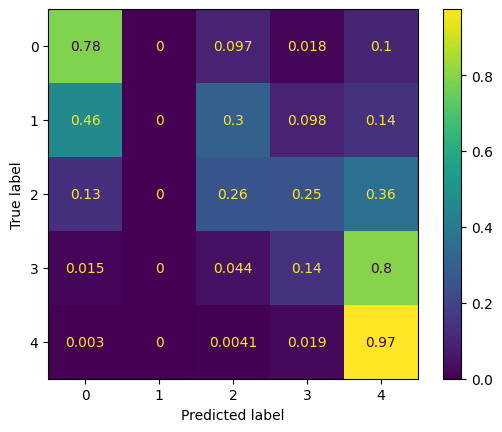

In [32]:
ConfusionMatrixDisplay.from_predictions(y_val_ohe.argmax(dim=1), model[0](X_val).argmax(dim=1), normalize = 'true')
plt.show()

In [37]:
rus = RandomUnderSampler(random_state = 123)

In [41]:
test_result_rus = []

for i in range(3):
    X_rus, y_rus = rus.fit_resample(X_train, y_train)
    X_rus_tt, X_rus_ho, y_rus_tt, y_rus_ho = train_test_split(X_rus, y_rus, test_size = 0.2)
        
    y_rus_tt = y_rus_tt.reshape(-1,1)
    y_rus_ho = y_rus_ho.reshape(-1,1)

    ohe_y_rus_tt = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(y_rus_tt)
    y_rus_tt_ohe = ohe_y_rus_tt.transform(y_rus_tt)

    ohe_y_rus_ho = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(y_rus_ho)
    y_rus_ho_ohe = ohe_y_rus_ho.transform(y_rus_ho)

    X_rus_tt = torch.tensor(X_rus_tt.tolist(), dtype = torch.float32)
    X_rus_ho = torch.tensor(X_rus_ho.tolist(), dtype = torch.float32)

    y_rus_tt_ohe = torch.tensor(y_rus_tt_ohe, dtype = torch.float32)
    y_rus_ho_ohe = torch.tensor(y_rus_ho_ohe, dtype = torch.float32)

    test_result_rus.append(train_model(model[0], 2, 10, X_rus_tt, y_rus_tt_ohe, X_rus_ho, y_rus_ho_ohe))

Epoch 0: 100%|██████████| 6021/6021 [00:25<00:00, 234.01batch/s, acc=0.5, loss=0.967]


Epoch 0 validation: Cross-entropy = 1.049569010734558, Accuracy = 0.5403574109077454


Epoch 0: 100%|██████████| 6021/6021 [00:25<00:00, 234.06batch/s, acc=0.8, loss=0.806]


Epoch 0 validation: Cross-entropy = 1.0458955764770508, Accuracy = 0.5393609404563904


Epoch 0: 100%|██████████| 6021/6021 [00:26<00:00, 229.92batch/s, acc=0.6, loss=1.02] 


Epoch 0 validation: Cross-entropy = 1.0340707302093506, Accuracy = 0.5415531992912292


Epoch 1: 100%|██████████| 6021/6021 [00:25<00:00, 233.17batch/s, acc=0.6, loss=0.982]


Epoch 1 validation: Cross-entropy = 1.0355058908462524, Accuracy = 0.5428818464279175


In [42]:
c_entropy(model[0](X_val), y_val_ohe) # Cross entropy on validation set

tensor(0.8956, grad_fn=<DivBackward1>)

In [43]:
(y_val_ohe.argmax(dim=1) == model[0](X_val).argmax(dim=1)).float().mean() # Accuracy on validation set

tensor(0.6279)

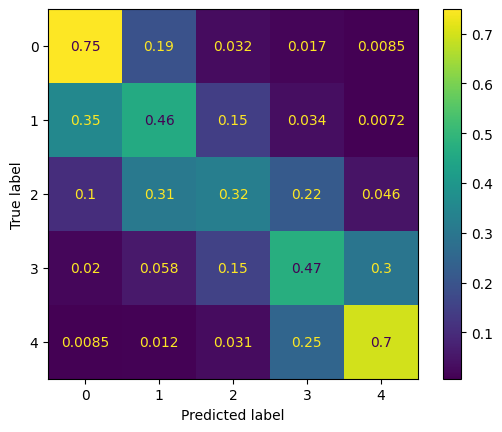

In [44]:
ConfusionMatrixDisplay.from_predictions(y_val_ohe.argmax(dim=1), model[0](X_val).argmax(dim=1), normalize = 'true')
plt.show()